Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 5: 100%|██████████| 2500/2500 [17:49<00:00,  2.34it/s, loss=0.00489]


Accuracy: 0.8675
Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.78      0.85      4961
    Positive       0.82      0.95      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



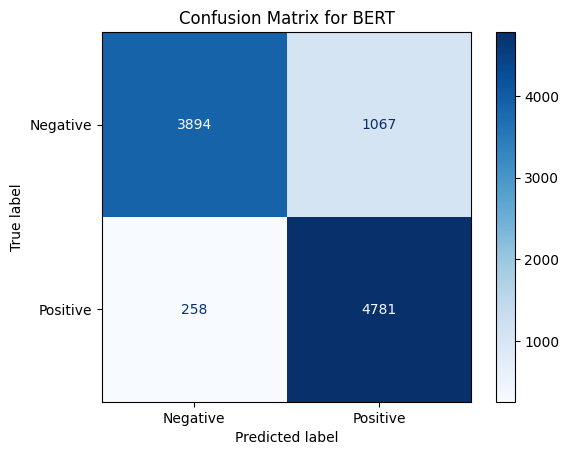

Predictions: ['positive', 'negative']


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess the dataset
df = pd.read_csv('IMDB_Dataset.csv')
df['processed_review'] = df['review'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)

# Use only a small subset for faster training
X_train_sample = X_train[:1000]
y_train_sample = y_train[:1000]

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = 1 if self.labels[idx] == 'positive' else 0
        encodings = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return encodings['input_ids'].squeeze(0), encodings['attention_mask'].squeeze(0), torch.tensor(label)

# Create datasets
train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist())
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist())

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for input_ids, attention_mask, labels in loop:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for BERT")
plt.show()

# Example prediction function
def predict(texts):
    model.eval()
    predictions = []
    for text in texts:
        encodings = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1).item()
            predictions.append('positive' if pred == 1 else 'negative')
    return predictions

# Predict on custom text
sample_texts = ["The movie was amazing!", 
                "I didn't like the movie at all."]
predictions = predict(sample_texts)
print(f"Predictions: {predictions}")


In [6]:
def predict_user_input():
    model.eval()  # Ensure the model is in evaluation mode

    # Take input from the user
    user_review = input("Enter a movie review: ")

    # Tokenize and encode the input
    encodings = tokenizer(user_review, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

    # Map prediction to sentiment
    sentiment = 'positive' if pred == 1 else 'negative'

    print(f"Prediction for the entered review: {sentiment}")

# Call the function to get user input and make a prediction
predict_user_input()

Enter a movie review: The movie was a big hit.
Prediction for the entered review: positive


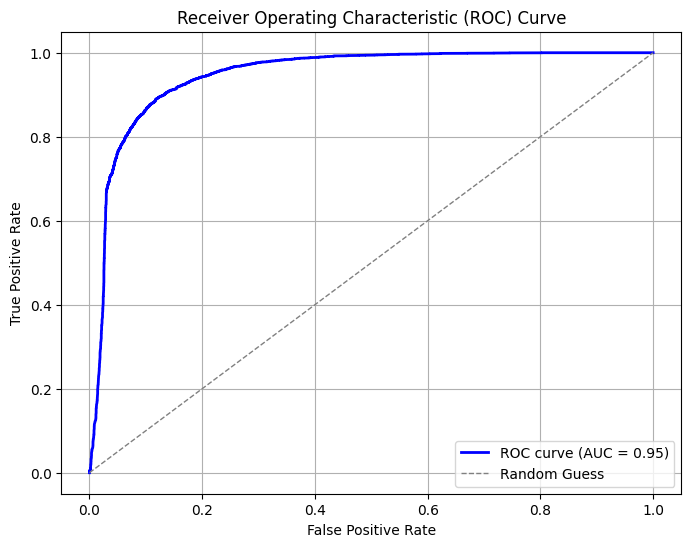

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Initialize lists for probabilities and true labels
y_probs = []
all_labels = []

# Collect predictions and true labels
model.eval()
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute softmax probabilities and collect positive class probabilities
        probabilities = torch.softmax(logits, dim=1)[:, 1]  # Probability of positive class
        y_probs.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_labels, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [11]:
validation_accuracies = []  # List to store accuracy for each epoch

for epoch in range(epochs):
    # Training (same as before)
    model.train()
    for input_ids, attention_mask, labels in train_loader:
        ...

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    validation_accuracies.append(accuracy)  # Store accuracy for this epoch


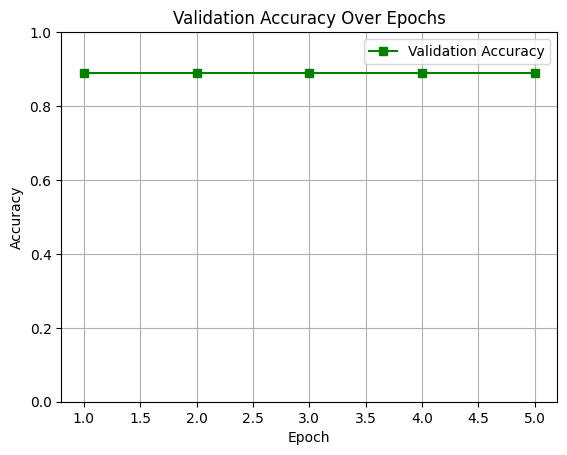

In [12]:
plt.plot(range(1, epochs + 1), validation_accuracies, marker='s', label='Validation Accuracy', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid()
plt.legend()
plt.show()


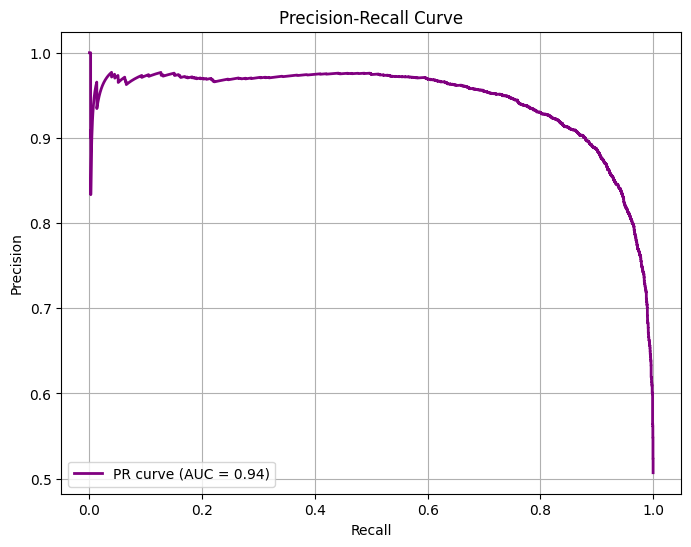

In [19]:
# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()


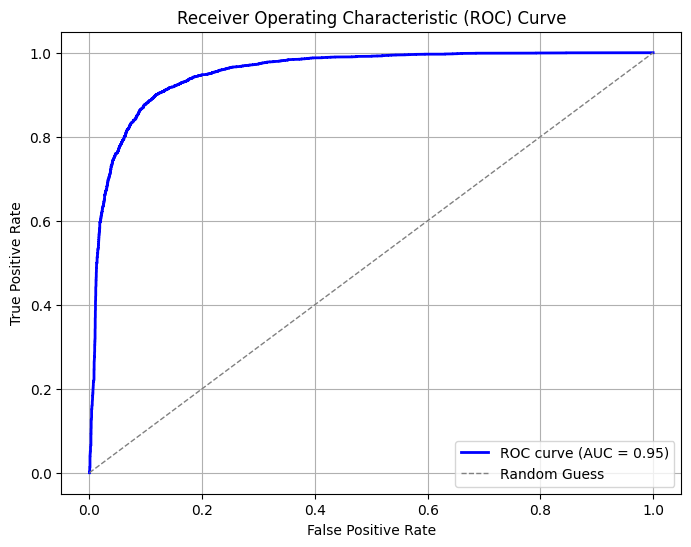

In [21]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()